In [1]:
from typing import Dict, List, Tuple, Union

import pandas as pd
import qlib
from qlib.data import D
from qlib.data.filter import NameDFilter
from FactorZoo import SportBettingsFactor
from src.build_factor import get_factors_frame,get_factor_name

In [2]:
qlib.init(provider_uri="data/qlib_data", region="cn")

[340840:MainThread](2023-06-28 16:42:31,776) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[340840:MainThread](2023-06-28 16:42:31,997) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[340840:MainThread](2023-06-28 16:42:31,998) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('D:/WorkSpace/QuantsPlaybook/B-因子构建类/个股动量效应的识别及“球队硬币”因子/data/qlib_data')}


In [3]:
# 进获取A股所有股票 qlib过滤器速度很慢 不如手动过滤
POOLS: List = D.list_instruments(
    D.instruments("CN", filter_pipe=[NameDFilter("(3|6|0)\d{5}\.(SH|SZ)")]),
    as_list=True,
)

data: pd.DataFrame = D.features(
    POOLS, fields=["$close", "$open", "$turnover_rate", "$turnover_rate_f"]
)
data.columns = data.columns.str.replace("$", "",regex=True)

In [17]:
data.head()

close        open  turnover_rate  turnover_rate_f
instrument datetime                                                          
000001.SZ  2013-01-04  578.406250  590.343384         1.4293           1.7178
           2013-01-07  589.619873  578.044556         1.1502           1.3823
           2013-01-08  578.768005  589.619873         1.0063           1.2093
           2013-01-09  573.703796  577.321106         0.8093           0.9727
           2013-01-10  574.065491  573.703796         0.7730           0.9290

In [4]:
factor_data: pd.DataFrame = get_factors_frame(
    data, 20, general_names=["interday", "intraday", "overnight"]
)
factor_data: pd.DataFrame = factor_data.sort_index()

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   34.2s finished


In [5]:
factor_data.head()

interday_volatility_reverse  \
datetime   instrument                                
2013-01-04 000001.SZ                           NaN   
           000004.SZ                           NaN   
           000005.SZ                           NaN   
           000006.SZ                           NaN   
           000007.SZ                           NaN   

                       interday_turnover_rate_reverse  \
datetime   instrument                                   
2013-01-04 000001.SZ                              NaN   
           000004.SZ                              NaN   
           000005.SZ                              NaN   
           000006.SZ                              NaN   
           000007.SZ                              NaN   

                       interday_turnover_rate_f_reverse  \
datetime   instrument                                     
2013-01-04 000001.SZ                                NaN   
           000004.SZ                                NaN   
           000005.SZ                                NaN   
           000006.SZ                                NaN   
           000007.SZ                                NaN   

                       revise_interday_reverse  intraday_volatility_reverse  \
datetime   instrument                                                         
2013-01-04 000001.SZ                       NaN                         -0.0   
           000004.SZ                       NaN                         -0.0   
           000005.SZ                       NaN                         -0.0   
           000006.SZ                       NaN                         -0.0   
           000007.SZ                       NaN                         -0.0   

                       intraday_turnover_rate_reverse  \
datetime   instrument                                   
2013-01-04 000001.SZ                              NaN   
           000004.SZ                              NaN   
           000005.SZ                              NaN   
           000006.SZ                              NaN   
           000007.SZ                              NaN   

                       intraday_turnover_rate_f_reverse  \
datetime   instrument                                     
2013-01-04 000001.SZ                                NaN   
           000004.SZ                                NaN   
           000005.SZ                                NaN   
           000006.SZ                                NaN   
           000007.SZ                                NaN   

                       revise_intraday_reverse  overnight_volatility_reverse  \
datetime   instrument                                                          
2013-01-04 000001.SZ                       NaN                           NaN   
           000004.SZ                       NaN                           NaN   
           000005.SZ                       NaN                           NaN   
           000006.SZ                       NaN                           NaN   
           000007.SZ                       NaN                           NaN   

                       overnight_turnover_rate_reverse  \
datetime   instrument                                    
2013-01-04 000001.SZ                               NaN   
           000004.SZ                               NaN   
           000005.SZ                               NaN   
           000006.SZ                               NaN   
           000007.SZ                               NaN   

                       overnight_turnover_rate_f_reverse  \
datetime   instrument                                      
2013-01-04 000001.SZ                                 NaN   
           000004.SZ                                 NaN   
           000005.SZ                                 NaN   
           000006.SZ                                 NaN   
           000007.SZ                                 NaN   

                       revise_overnight_reverse  
datetime   instrument  

In [6]:
import empyrical as ep
from alphalens.utils import get_clean_factor_and_forward_returns

In [7]:
def get_clean_factor(
    factor_ser: pd.DataFrame,
    data: pd.DataFrame,
    quantiles: int = 10,
    periods: Tuple = (1, 5, 22),
    **kwargs
) -> pd.DataFrame:
    pricing: pd.DataFrame = pd.pivot_table(
        data.reset_index(), index="datetime", columns="instrument", values="close"
    )
    dropna_ser: pd.Series = factor_ser.where(factor_ser != 0).dropna()
    return get_clean_factor_and_forward_returns(
        dropna_ser, pricing.shift(-1), quantiles=quantiles, periods=periods
    )

In [8]:
factors:List = factor_data.columns.tolist()

In [9]:
dfs:List = []

for factor_name in factors:

    clean_factor:pd.DataFrame = get_clean_factor(factor_data[factor_name],data)
    ret_df:pd.DataFrame = pd.pivot_table(clean_factor.reset_index(),index="date",columns="factor_quantile",values="1D")
    cum_df:pd.DataFrame = ep.cum_returns(ret_df)
    cum_df['factor_name'] = factor_name
    dfs.append(cum_df)

Dropped 1.4% entries from factor data: 1.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.3% entries from factor data: 1.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.3% entries from factor data: 1.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.3% entries from factor data: 1.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.4% entries from factor data: 1.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.3% en

In [10]:
factors_cum:pd.DataFrame = pd.concat(dfs,axis=0,sort=True)

In [11]:
lines_df:pd.DataFrame = pd.melt(factors_cum.reset_index(),id_vars=['date','factor_name'])

In [12]:
import seaborn as sns
import seaborn.objects as so

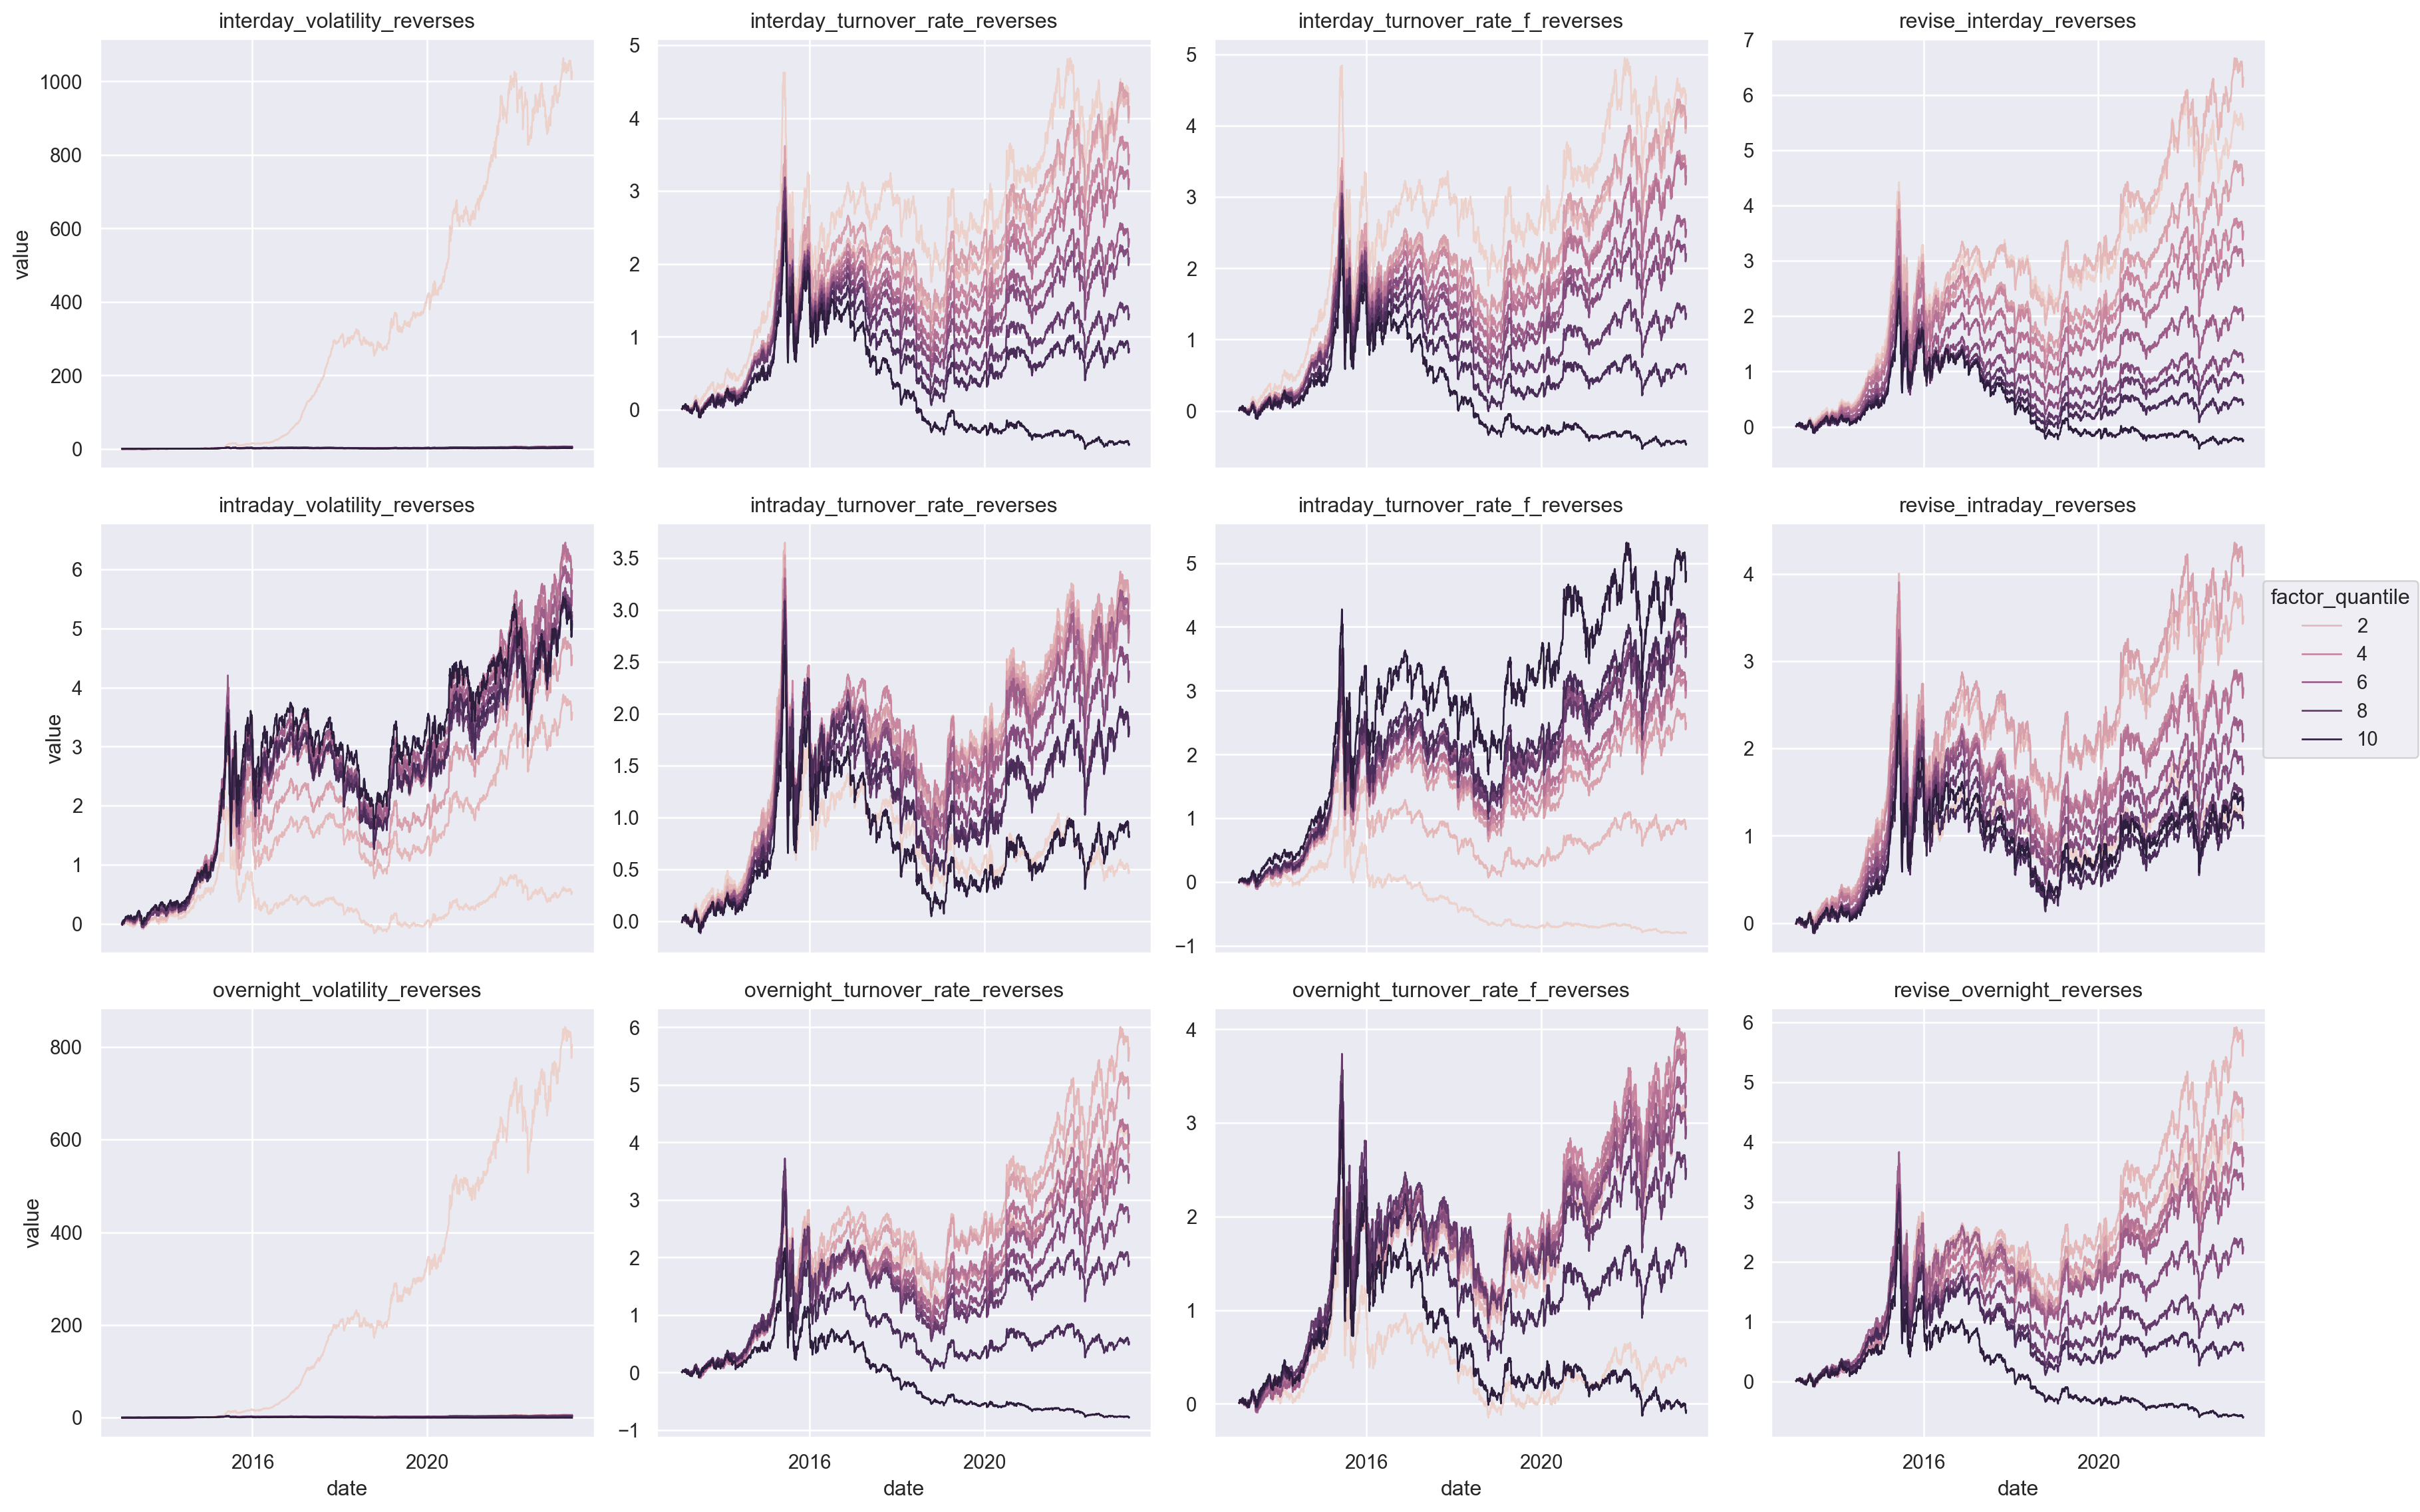

In [13]:
(
    so.Plot(x=lines_df["date"], y=lines_df["value"], color=lines_df["factor_quantile"])
    .facet(lines_df["factor_name"], wrap=4)
    .share(y=False)
    .add(so.Lines(linewidth=1))
    .layout(size=(18, 12))
    .label(title="{}s".format)
)

In [14]:
slice_df:pd.DataFrame = dfs[0]

In [18]:
from alphalens import performance as perf
from alphalens import tears
from alphalens import utils

In [19]:
input_periods = utils.get_forward_returns_columns(
            clean_factor.columns, require_exact_day_multiple=True,
        ).values #.get_values()
turnover_periods = utils.timedelta_strings_to_integers(input_periods)

d:\anaconda3\envs\qlib_env\lib\site-packages\alphalens\utils.py:910: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


In [23]:
quantile_factor = clean_factor["factor_quantile"]


quantile_turnover = {
        p: pd.concat(
            [
                perf.quantile_turnover(quantile_factor, q, p)
                for q in quantile_factor.sort_values().unique().tolist()
            ],
            axis=1,
        )
        for p in turnover_periods
    }

In [29]:
turnover_periods

[1, 5, 22]

<Axes: xlabel='date'>

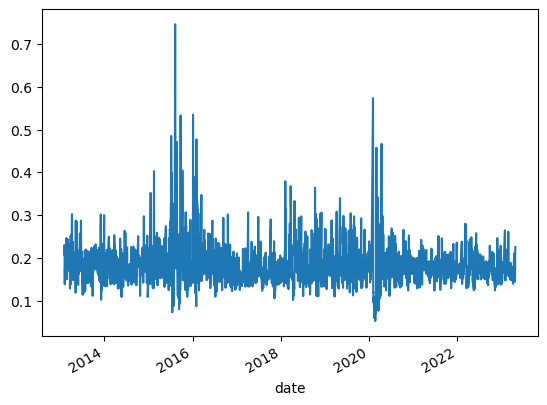

In [31]:
perf.quantile_turnover(quantile_factor, 1, 1).plot()

<Axes: xlabel='date'>

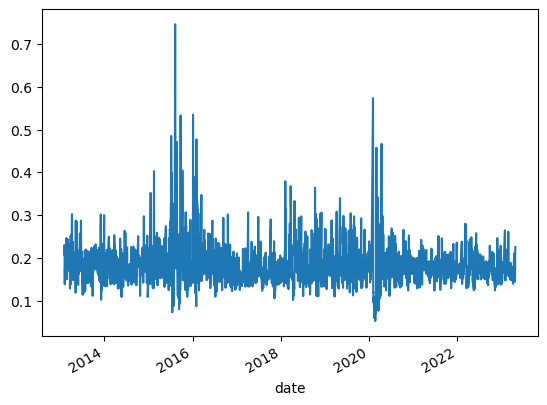

In [27]:
quantile_turnover[1][1].plot()

d:\anaconda3\envs\qlib_env\lib\site-packages\alphalens\utils.py:910: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


Turnover Analysis


d:\anaconda3\envs\qlib_env\lib\site-packages\alphalens\plotting.py:153: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for quantile, p_data in quantile_turnover[period].iteritems():
d:\anaconda3\envs\qlib_env\lib\site-packages\alphalens\plotting.py:153: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for quantile, p_data in quantile_turnover[period].iteritems():
d:\anaconda3\envs\qlib_env\lib\site-packages\alphalens\plotting.py:153: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for quantile, p_data in quantile_turnover[period].iteritems():
d:\anaconda3\envs\qlib_env\lib\site-packages\alphalens\plotting.py:157: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for period, p_data in autocorrelation_data.iteritems():


,1D,5D,22D
Quantile 1 Mean Turnover,0.182,0.443,0.842
Quantile 2 Mean Turnover,0.401,0.703,0.877
Quantile 3 Mean Turnover,0.496,0.768,0.887
Quantile 4 Mean Turnover,0.539,0.796,0.893
Quantile 5 Mean Turnover,0.553,0.807,0.897
Quantile 6 Mean Turnover,0.549,0.805,0.899
Quantile 7 Mean Turnover,0.522,0.791,0.898
Quantile 8 Mean Turnover,0.468,0.759,0.891
Quantile 9 Mean Turnover,0.369,0.684,0.877
Quantile 10 Mean Turnover,0.174,0.426,0.808


,1D,5D,22D
Mean Factor Rank Autocorrelation,0.948,0.77,0.209


<Figure size 640x480 with 0 Axes>

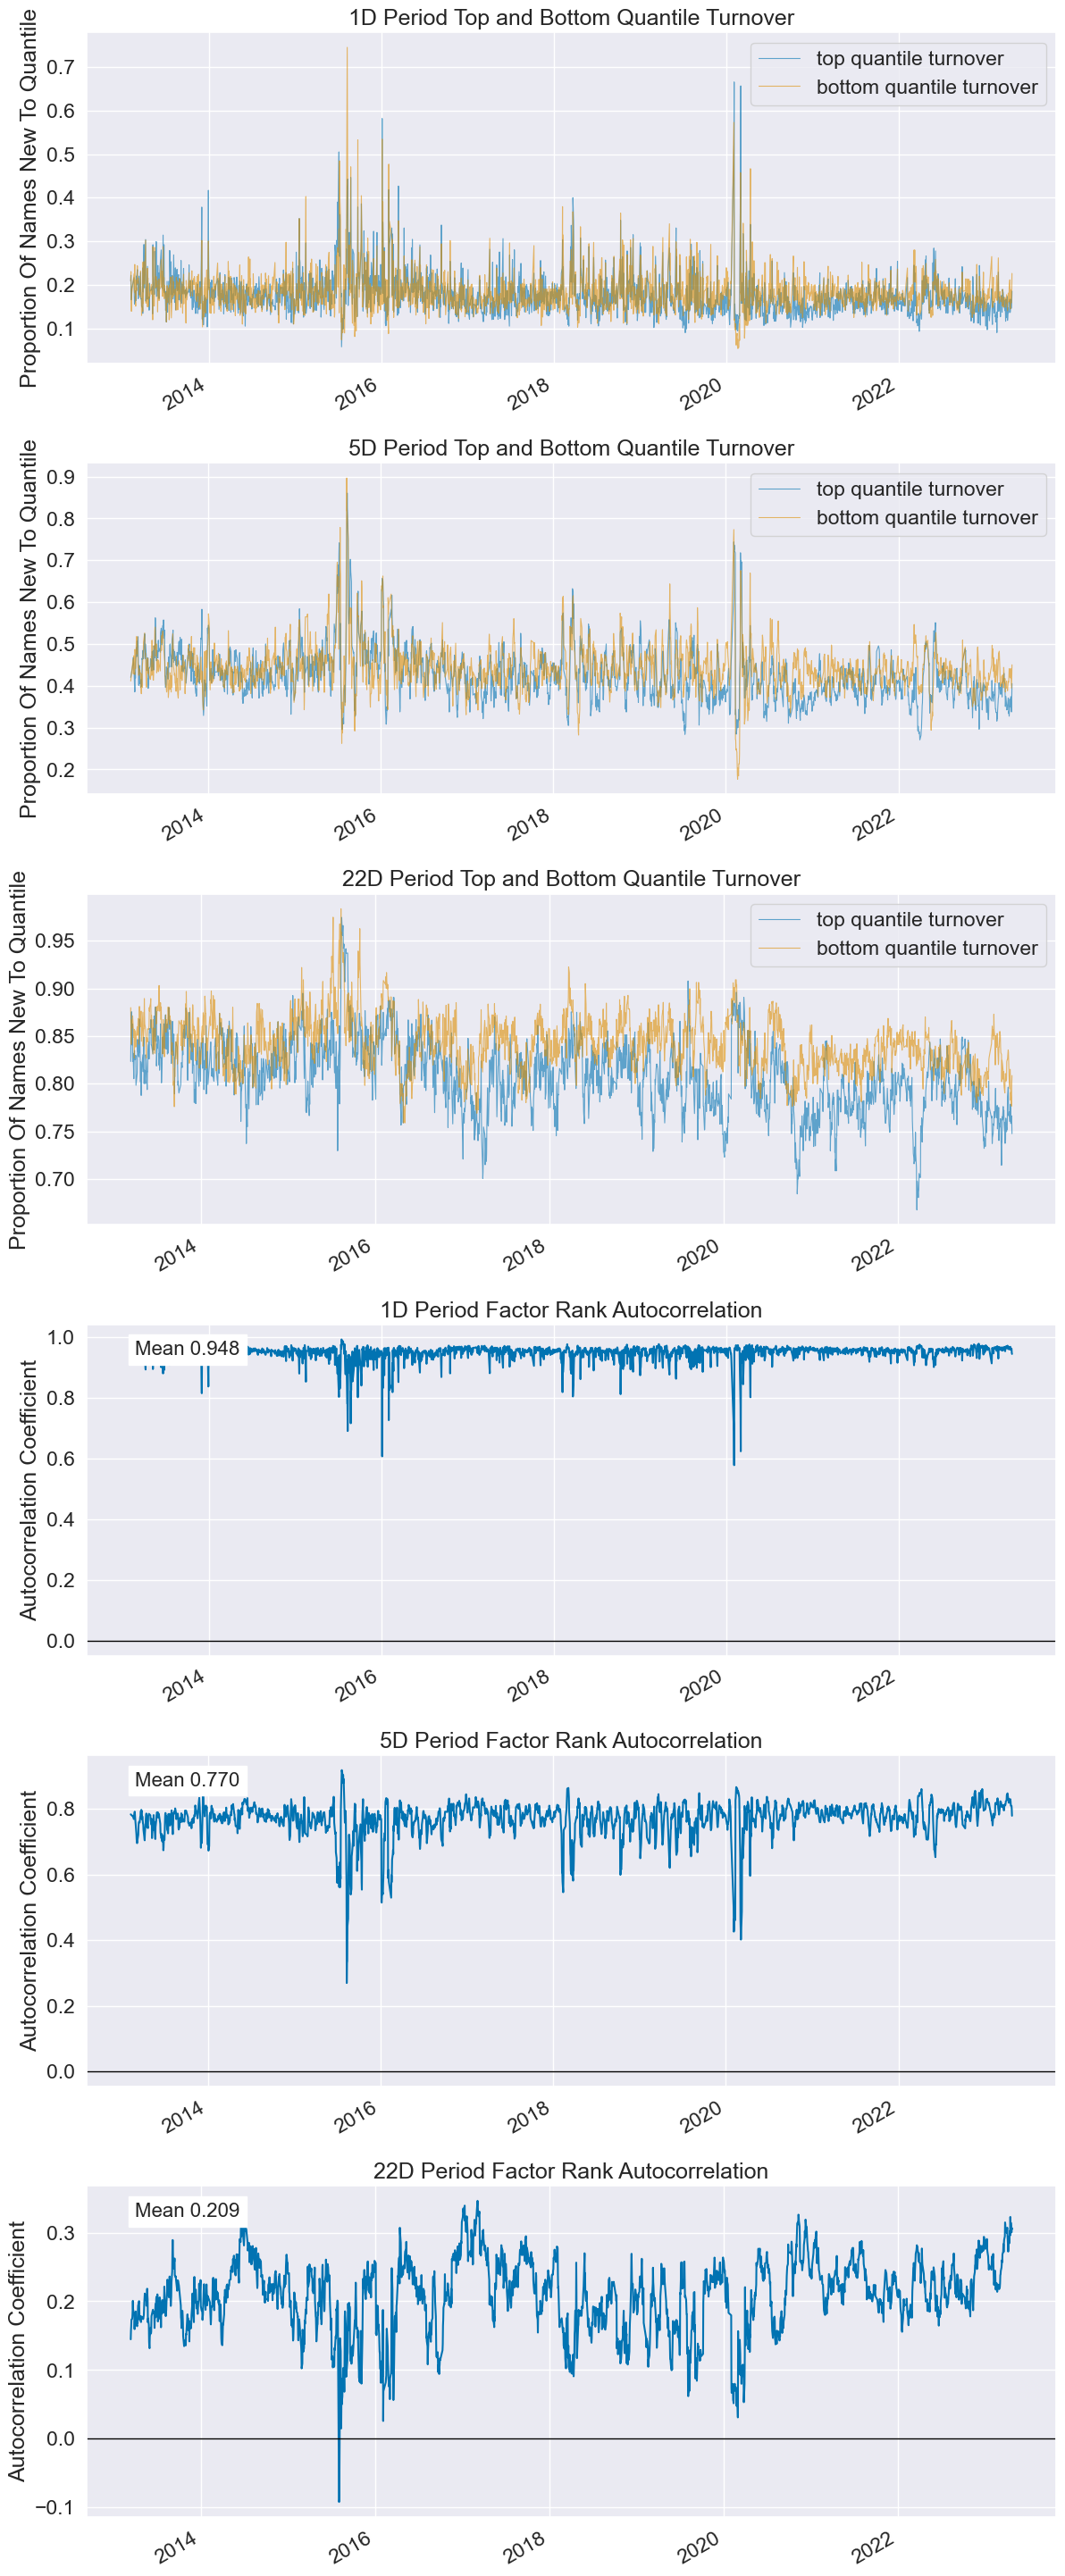

In [16]:
tears.create_turnover_tear_sheet(clean_factor)